# Qats & Doqs

In [1]:
# On importe les librairies dont on aura besoin pour ce tp
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sensor

In [2]:
@qml.template
def sensor(datas, wires):
    qml.RX(datas[0], wires=wires[0])
    if len(datas) == 3:
        qml.RY(datas[1], wires=wires[0])
        qml.RZ(datas[2], wires=wires[0])
    else:
        qml.RZ(datas[1], wires=wires[0])

## Classifier

In [3]:
@qml.template
def classifier(params, wires):
    # qml.RZ(params, wires=wires[0])
    # qml.RY(params, wires=wires[0])
    n_qubits = len(wires)
    n_rotations = len(params)
    n_layers = n_rotations // n_qubits

    if n_rotations % n_qubits != 0:
        raise Exception("Last layer is incomplete, not all qubits are rotated")

    # Alternating layers of unitary rotations on every qubit followed by a
    # ring cascade of CNOTs.
    for layer_idx in range(n_layers):
        layer_params = params[layer_idx * n_qubits: layer_idx * n_qubits + n_qubits, :]
        qml.broadcast(qml.Rot, wires, pattern="single", parameters=layer_params)
        if n_qubits > 1:
            qml.broadcast(qml.CNOT, wires, pattern="ring")

## Init data sensor

In [4]:
"""
   To use your dataset just change the csv file call 
"""
csv_training = pd.read_csv('datas/training_data_xz.csv', header=None)
csv_testing = pd.read_csv('datas/testing_data_xz.csv', header=None)

## Training

In [12]:
print("##################################################################\n"
      "# TRAINING")
"""
    Variables :
    data_training : the xy // xyz data for only 1 qubit
    label_training : the label for only 1 qubit
    n_layers : deep level
    weights : the angle for the classifier
"""

dev = qml.device('default.qubit', wires=1, shots=1)
n_qubits = len(dev.wires)
n_layers = 2
weights = np.random.uniform(low=-np.pi, high=np.pi, size=(n_layers * n_qubits, 3))

if csv_training.shape[1] == 3:
    prediction = [[], [], []]
else:
    prediction = [[], [], [], []]

#for i in range(len(csv_training[0])):
for i in range(20):
    if csv_training.shape[1] == 3:
        data_training = [csv_training[0][i], csv_training[1][i]]
        label_training = csv_training[2][i]
    else:
        data_training = [csv_training[0][i], csv_training[1][i], csv_training[2][i]]
        label_training = csv_training[3][i]


    @qml.qnode(dev)
    def circuit(datas, params):
        sensor(datas, wires=[0])
        classifier(params, wires=dev.wires)
        return qml.sample(qml.PauliZ(0))

    result = circuit(data_training, weights)
    prob = result
    
    # Graph and check error
    prediction[0].append(data_training[0])
    prediction[1].append(data_training[1])
    if csv_training.shape[1] == 3:
        prediction[2].append(prob)
        print("Data : {} ; {} = {}".format(data_training[0], data_training[1], prob))
    else:
        prediction[2].append(data_training[2])
        prediction[3].append(prob)
        print("Data : {} ; {} ; {} = {}".format(data_training[0], data_training[1], data_training[1], prob))

print("\nTraining done !")

##################################################################
# TRAINING
Data : 1.310305388 ; 5.265837637 = -1
Data : 1.807496019 ; 4.473977389 = -1
Data : 1.8280737 ; 4.368759399 = 1
Data : 2.250278501 ; 2.510486673 = 1
Data : 0.809597564 ; 1.625995122 = -1
Data : 0.835273499 ; 3.986924917 = -1
Data : 1.5964400509999999 ; 5.485240276 = 1
Data : 0.917451826 ; 0.198000957 = -1
Data : 0.76161686 ; 4.235469558999999 = -1
Data : 1.3332371790000002 ; 1.454580258 = 1
Data : 2.120605062 ; 6.156591822 = 1
Data : 0.307872493 ; 2.65818269 = -1
Data : 0.057841418 ; 3.783048605 = -1
Data : 0.356434894 ; 4.167260741000001 = -1
Data : 1.700653184 ; 4.222820391 = -1
Data : 3.0563560439999997 ; 1.51385785 = 1
Data : 0.7811078290000001 ; 1.5877816790000001 = -1
Data : 1.723835215 ; 1.41360815 = 1
Data : 3.1110457360000003 ; 3.8131968169999997 = 1
Data : 3.071292306 ; 4.311176623 = 1

Training done !


## Graph and check error

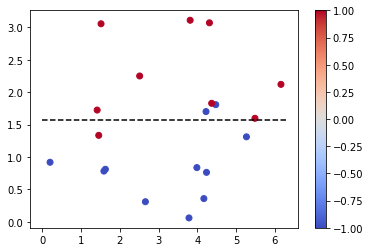

In [13]:
if len(prediction) == 3:
    plt.scatter(prediction[1], prediction[0], c=prediction[2], cmap="coolwarm")
    plt.plot([0,2*np.pi], [np.pi/2, np.pi/2], linestyle='--', c='#000000')
    plt.colorbar()
else:
    fig = plt.figure().gca(projection='3d')
    fig.scatter(prediction[0], prediction[1], prediction[2], c=prediction[3], cmap="coolwarm")
plt.show()